In this notebook we demonstrate how to leverage [FinBert](https://github.com/ProsusAI/finBERT) to classify the sentiment of a stocks.<br>You can download pre-trained FinBERT from [here](https://drive.google.com/drive/folders/1rcRXZhb3JLY3A_kIO8gMk8jacRyR-Ik6)

Huge shoutout to this [article](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99) which helped in using wget to download the pre-trained model.<br>
To Download any version of FinBERT follow these steps:
1. Open the drive link and open the folder of the model you want to download.
2. Right click on a file in the folder and select "get sharable link" option.
3. Copy the part after 'd/' in the sharable URL.
4. Replace the ID youve obtained intead of the id in the wget url if its different.
5. Repeat the process for the other file in the folder.<br>
`!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILEID" -O pytorch_model.bin && rm -rf /tmp/cookies.txt `

In [ ]:
## To install only the requirements of this notebook, uncomment the lines below and run this cell
!pip install requests==2.23.0
!pip install pytorch-transformers==1.2.0
!pip install transformers==4.7.0
!pip install pytorch-pretrained-bert==0.6.2
!pip install pytorch-nlp==0.5.0
!pip install pandas==1.1.5
!pip install tensorflow #==1.14.0
!pip install torch #==1.9.0
!pip install scikit-learn==0.21.3
!pip install tqdm==4.41.1
!pip install matplotlib==3.2.2
!pip install numpy==1.19.5
!pip install wget==3.2
## To install the requirements for the entire chapter, uncomment the lines below and run this cell
# try:
#   import google.colab
#   !curl  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch10/ch10-requirements.txt | xargs -n 1 -L 1 pip install
# except ModuleNotFoundError:
#   !pip install -r "ch10-requirements.txt"

     |████████████████████████████████| 176 kB 12.5 MB/s 
     |████████████████████████████████| 1.2 MB 50.1 MB/s 
     |████████████████████████████████| 131 kB 49.3 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 8.1 MB 46.0 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 138 kB 50.7 MB/s 
     |████████████████████████████████| 127 kB 48.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 2.5 MB 12.3 MB/s 
     |████████████████████████████████| 3.3 MB 49.7 MB

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import requests
import wget

## linke to the FinBERT
# https://drive.google.com/file/d/1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL/view?usp=sharing 
# https://drive.google.com/file/d/1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN/view?usp=sharing

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

### Model Weights

In [ ]:
try:
  print ('Use Wget to download model weights\n')
  import google.colab
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL" -O pytorch_model.bin && rm -rf /tmp/cookies.txt
except ModuleNotFoundError:
  file_id = '1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL'
  destination = 'Data/pytorch_model.bin'
  download_file_from_google_drive(file_id, destination)

Use Wget to download model weights

--2021-11-14 21:05:32--  https://docs.google.com/uc?export=download&confirm=4X1w&id=1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL
Resolving docs.google.com (docs.google.com)... 108.177.15.113, 108.177.15.102, 108.177.15.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.15.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-58-docs.googleusercontent.com/docs/securesc/gr0sh52orr4kfstmol8u4mmbeoiesg8k/2ldnb0ls3ea2s8t62boadmct6bngk6sl/1636923900000/03819273116678412817/04850384992692645808Z/1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL?e=download [following]
--2021-11-14 21:05:32--  https://doc-0o-58-docs.googleusercontent.com/docs/securesc/gr0sh52orr4kfstmol8u4mmbeoiesg8k/2ldnb0ls3ea2s8t62boadmct6bngk6sl/1636923900000/03819273116678412817/04850384992692645808Z/1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL?e=download
Resolving doc-0o-58-docs.googleusercontent.com (doc-0o-58-docs.googleusercontent.com)... 173.194.76.13

# Config.json

In [ ]:
try:
  print ('Use Wget to download model config\n')
  import google.colab
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN" -O config.json && rm -rf /tmp/cookies.txt
except ModuleNotFoundError:
  file_id = '1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN'
  destination = 'Data/bert_config.json'
  download_file_from_google_drive(file_id, destination)

Use Wget to download model config

--2021-11-14 21:05:40--  https://docs.google.com/uc?export=download&confirm=&id=1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN
Resolving docs.google.com (docs.google.com)... 142.251.5.100, 142.251.5.139, 142.251.5.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.5.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-48-docs.googleusercontent.com/docs/securesc/3j2h3iuacr87a03ont3ldji0vfvgfhgu/mqh8rhkpvo585aebdg4i96l95rqsn2ib/1636923900000/03819273116678412817/10416728324138027238Z/1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN?e=download [following]
--2021-11-14 21:05:40--  https://doc-0c-48-docs.googleusercontent.com/docs/securesc/3j2h3iuacr87a03ont3ldji0vfvgfhgu/mqh8rhkpvo585aebdg4i96l95rqsn2ib/1636923900000/03819273116678412817/10416728324138027238Z/1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN?e=download
Resolving doc-0c-48-docs.googleusercontent.com (doc-0c-48-docs.googleusercontent.com)... 173.194.76.132, 2a00:1

# Vocabulary
Finbert drive link does not have a vocab.txt file. In the FinBERT repo they have mentioned that the same vocab file was used as for the 'bert-base-uncased' model. So we are going to download the vocab.txt of the 'bert-base-uncased' model.

In [ ]:
try :
  import google.colab
  wget.download("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt")

except ModuleNotFoundError :
  wget.download("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt", "Data")

### Move all the files into a FinBERT directory. This is the format that is required by the huggingface transformers library.

In [ ]:
try :
  import google.colab     
  !mkdir finbert
  !mv pytorch_model.bin finbert/
  !mv config.json finbert/
  !mv bert-base-uncased-vocab.txt vocab.txt
  !mv vocab.txt finbert/
  
except ModuleNotFoundError:
  import os
  import shutil
  os.mkdir('Data/finbert')
  shutil.move('Data/pytorch_model.bin' , 'Data/finbert')
  shutil.move('Data/bert_config.json', 'Data/finbert')
  shutil.copyfile('Data/finbert/bert_config.json','Data/finbert/config.json')
  os.rename('Data/bert-base-uncased-vocab.txt' , 'Data/vocab.txt')
  shutil.move('Data/vocab.txt', 'Data/finbert')

### Import the model to confirm if everything is fine.

In [ ]:
from pytorch_transformers import BertModel
try :
  import google.colab 
  model = BertModel.from_pretrained('finbert')
except ModuleNotFoundError :
  model = BertModel.from_pretrained('Data/finbert')

From here it will be he same as the IMDB_sentiment_classification and BioBERT_Demo notebooks respectively so we will not re-explain every step.

In [ ]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available() :
  n_gpu = torch.cuda.device_count()
  torch.cuda.get_device_name(0)

You can download the dataset from [stochtwits](https://api.stocktwits.com/developers/docs). Please respect their policy of only 200 requests per hour.<br>
The dataset we created with the help of the API can be found under the Data folder in Ch10's folder of this repo. 

In [ ]:
#importing the dataset
try :
  print('Not using Colab\n')
  # download 'FinBERT_Data.csv' present in Data folder
  !wget https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch10/Data/FinBERT_Data.csv -O "FinBERT_Data.csv"
except ModuleNotFoundError :
  from google.colab import files
  uploaded = files.upload()

Not using Colab

--2021-11-14 21:06:14--  https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch10/Data/FinBERT_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338745 (331K) [text/plain]
Saving to: ‘FinBERT_Data.csv’

FinBERT_Data.csv    100%[===================>] 330.81K  --.-KB/s    in 0.01s   

2021-11-14 21:06:14 (22.3 MB/s) - ‘FinBERT_Data.csv’ saved [338745/338745]



In [ ]:
import pandas as pd
try : 
  import google.colab 
  df = pd.read_csv("FinBERT_Data.csv")
except ModuleNotFoundError :
  df = pd.read_csv("Data/FinBERT_Data.csv")

df.head()

,symbol,sentiment,message,message_id
0,GOOGL,Bullish,$GOOGL want to know how to get more day trades...,216640409
1,GOOGL,Bullish,$googl $amzn $fb\nWhy we still bullish? Good v...,216632254
2,GOOGL,Bullish,$tsla $aapl $googl\nTsla ideas \nhttps://youtu...,216621697
3,GOOGL,Bearish,$AAPL $AMZN $GOOGL $FB $MSFT \nTime to short t...,216598529
4,FB,Bearish,2020 is not even close to being over.. \nBig B...,216673119


In [ ]:
print(display(df['symbol'].value_counts()))
print(df['sentiment'].value_counts())
df.shape

FB       823
AMZN     671
GOOGL    620
Name: symbol, dtype: int64

None
Bullish    1426
Bearish     688
Name: sentiment, dtype: int64


(2114, 4)

In [ ]:
from sklearn.preprocessing import LabelEncoder
#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,symbol,sentiment,message,message_id
0,GOOGL,1,$GOOGL want to know how to get more day trades...,216640409
1,GOOGL,1,$googl $amzn $fb\nWhy we still bullish? Good v...,216632254
2,GOOGL,1,$tsla $aapl $googl\nTsla ideas \nhttps://youtu...,216621697
3,GOOGL,0,$AAPL $AMZN $GOOGL $FB $MSFT \nTime to short t...,216598529
4,FB,0,2020 is not even close to being over.. \nBig B...,216673119


In [ ]:
message = list(df['message'])
try :
  import google.colab
  tokenizer = BertTokenizer.from_pretrained('finbert', do_lower_case=True)

except ModuleNotFoundError :
    tokenizer = BertTokenizer.from_pretrained('Data/finbert', do_lower_case=True)

In [ ]:
# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: ['[CLS]']+tokenizer.tokenize(t)+['[SEP]'] , message))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', '$', 'goo', '##gl', 'want', 'to', 'know', 'how', 'to', 'get', 'more', 'day', 'trades', 'with', 'google', 'and', 'any', 'other', 'stock', 'under', '25', '##k', 'and', '3', 'day', 'trades', 'in', '5', 'days', '?', 'try', 'this', 'youtube', '.', 'com', '/', 'watch', '?', 'v', '=', 'j', '##z', '##9', '_', 'c', '-', '5', '[SEP]']


In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
batch_size = 16
classes = list(df['sentiment'])
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, classes, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)                              
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#Loading pre trained BERT
try :
  import google.colab
  model = BertForSequenceClassification.from_pretrained("finbert", num_labels=2)
except ModuleNotFoundError :
  model = BertForSequenceClassification.from_pretrained("Data/finbert", num_labels=2)
if torch.cuda.is_available() :    
  print(model.cuda())
else :
  print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6259812076552576


Epoch:  25%|██▌       | 1/4 [01:41<05:05, 101.85s/it]

Validation Accuracy: 0.7321428571428571
Train loss: 0.417024488646944


Epoch:  50%|█████     | 2/4 [03:23<03:23, 101.84s/it]

Validation Accuracy: 0.78125
Train loss: 0.17178611787615203


Epoch:  75%|███████▌  | 3/4 [05:05<01:41, 101.83s/it]

Validation Accuracy: 0.7589285714285714
Train loss: 0.07903678193610131


Epoch: 100%|██████████| 4/4 [06:47<00:00, 101.81s/it]

Validation Accuracy: 0.7633928571428571


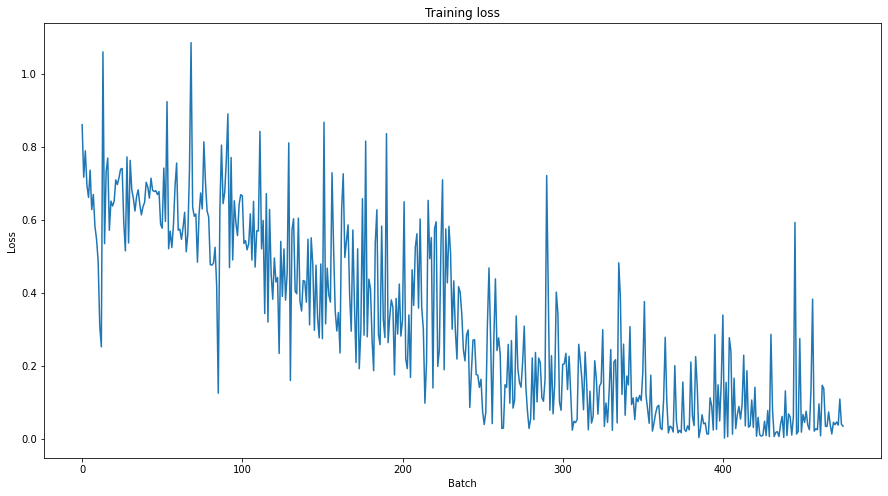

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
    ## TRAINING

    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

We achieved a validation accuracy of 73% in the last epoch. This is just a demonstration, we might be able to achieve higher accuracies by performing some pre-processing steps and hyper parameter tuning.